In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import json

In [2]:
df_high = pd.read_csv("high_manifest_all.csv", index_col=0)
df_low = pd.read_csv("low_manifest_all.csv", index_col=0)

In [3]:
print(df_high.shape[0], df_low.shape[0])

255 1034


In [4]:
df_low = df_low.loc[df_low["UCSC_RefGene_Group"].dropna().index]
df_high = df_high.loc[df_high["UCSC_RefGene_Group"].dropna().index]

In [5]:
print(df_high.shape[0], df_low.shape[0])

182 751


In [6]:
high_promoters = []
df_high_promoters = pd.DataFrame(index=df_high.index.tolist(), columns=["Promoter"])
for cpg in df_high.index:
    gene_names = df_high.loc[cpg, "UCSC_RefGene_Name"].split(";")
    gene_groups = df_high.loc[cpg, "UCSC_RefGene_Group"].split(";")
    for i in range(len(gene_groups)):
        if gene_groups[i]=="TSS1500" or gene_groups[i]=="TSS200" or gene_groups[i]=="1stExon" or gene_groups[i]=="5'UTR":
            high_promoters.append(gene_names[i])
            df_high_promoters.loc[cpg, "Promoter"] = gene_names[i]
            
df_high_promoters = df_high_promoters.dropna()

In [7]:
low_promoters = []
df_low_promoters = pd.DataFrame(index=df_low.index.tolist(), columns=["Promoter"])
for cpg in df_low.index:
    gene_names = df_low.loc[cpg, "UCSC_RefGene_Name"].split(";")
    gene_groups = df_low.loc[cpg, "UCSC_RefGene_Group"].split(";")
    for i in range(len(gene_groups)):
        if gene_groups[i]=="TSS1500" or gene_groups[i]=="TSS200" or gene_groups[i]=="1stExon" or gene_groups[i]=="5'UTR":
            low_promoters.append(gene_names[i])
            df_low_promoters.loc[cpg, "Promoter"] = gene_names[i]
            
df_low_promoters = df_low_promoters.dropna()

In [8]:
print(df_high_promoters.shape[0], df_low_promoters.shape[0])

70 220


In [9]:
df_high_promoters.to_csv("high_promoters_allCpGs.csv")
df_low_promoters.to_csv("low_promoters_allCpGs.csv")

-----

# enrichr

In [53]:
import gseapy as gp
from gseapy import dotplot, barplot

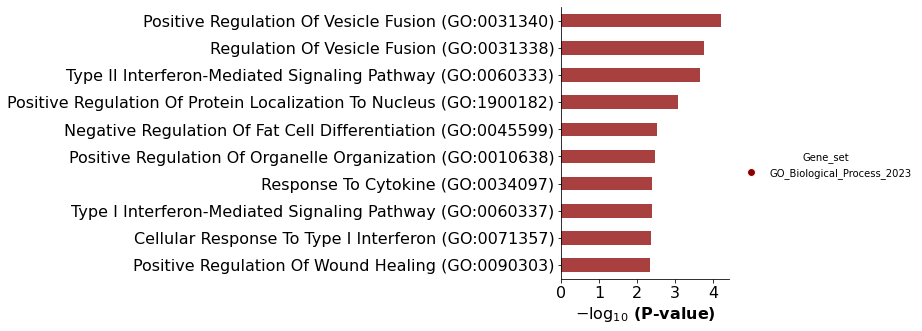

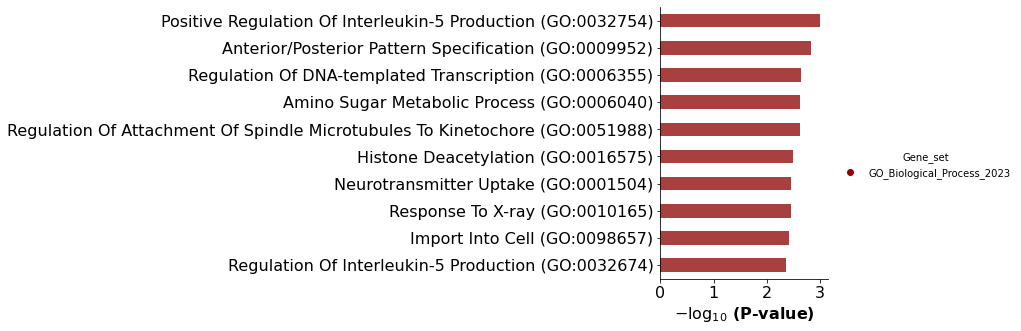

In [54]:
for gene_list in [high_promoters, low_promoters]:
    enr = gp.enrichr(gene_list=list(set(gene_list)), # or "./tests/data/gene_list.txt",
                     gene_sets=['GO_Biological_Process_2023'],
                     organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                     outdir=None, # don't write to disk
                    )
    ax = barplot(enr.results,
              column="P-value",
              group='Gene_set', # set group, so you could do a multi-sample/library comparsion
              size=10,
              top_term=10,
              figsize=(3,5),
              cutoff=1,
              color=['darkred'] # set colors for group
             )
    plt.show()

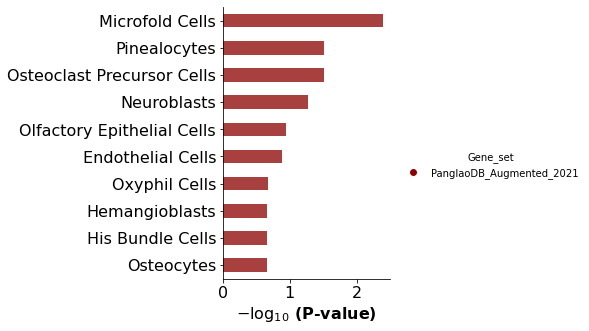

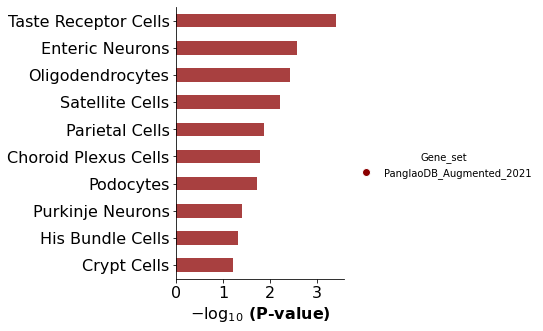

In [55]:
for gene_list in [high_promoters, low_promoters]:
    enr = gp.enrichr(gene_list=list(set(gene_list)), # or "./tests/data/gene_list.txt",
                     gene_sets=['PanglaoDB_Augmented_2021'],
                     organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                     outdir=None, # don't write to disk
                    )
    ax = barplot(enr.results,
              column="P-value",
              group='Gene_set', # set group, so you could do a multi-sample/library comparsion
              size=10,
              top_term=10,
              figsize=(3,5),
              cutoff=1,
              color=['darkred'] # set colors for group
             )
    plt.show()

# GBMap

In [10]:
# adata = sc.read("/data/projects/robin/cell_free2/Extended_GBmap.h5ad")
adata = sc.read("/data/projects/robin/cell_free/proteomics_WGCNA/figures/notebooks/data/core_GBmap.h5ad")

In [11]:
adata.var_names = adata.var.feature_name.tolist()

In [12]:
sc.pp.scale(adata)

In [13]:
high_promoters = list(set(pd.read_csv("high_promoters_allCpGs.csv")["Promoter"].tolist()))
low_promoters = list(set(pd.read_csv("low_promoters_allCpGs.csv")["Promoter"].tolist()))

In [14]:
high_promoters = [e for e in high_promoters if e in adata.var_names]
low_promoters = [e for e in low_promoters if e in adata.var_names]

In [15]:
name, gene_list = "high_promoters", high_promoters
sc.tl.score_genes(adata, gene_list=list(set(gene_list)), score_name="{}_score".format(name),
                 use_raw=False)

In [16]:
name, gene_list = "low_promoters", low_promoters
sc.tl.score_genes(adata, gene_list=list(set(gene_list)), score_name="{}_score".format(name),
                 use_raw=False)

In [28]:
sc.set_figure_params(dpi=100)

In [29]:
cmap = "turbo"

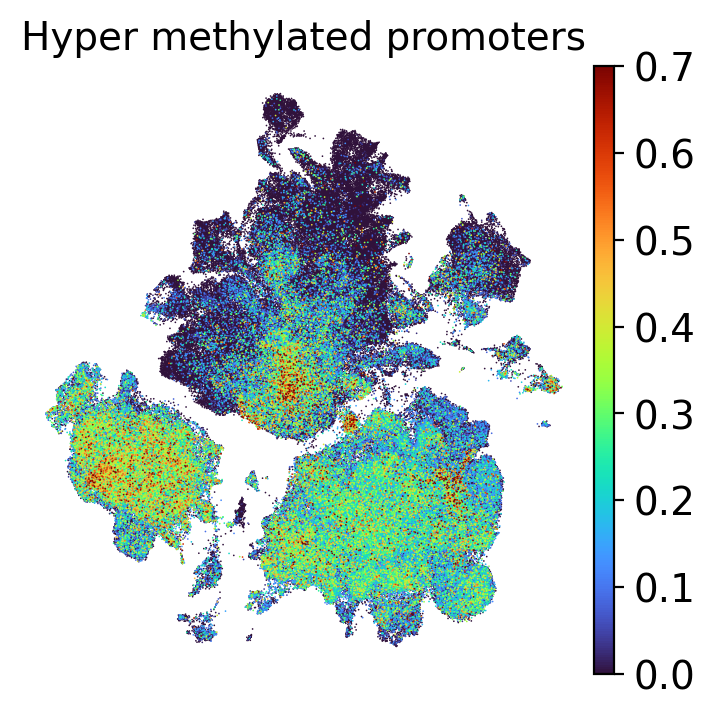

In [30]:
name = "high_promoters"
sc.pl.umap(adata, color=["{}_score".format(name)], 
            cmap=cmap, 
            ncols=1.5, 
            vmax=0.7,
            vmin=0,
            legend_fontsize=7, 
            legend_fontoutline=3, 
            s=1.5, 
            title=["Hyper methylated promoters"],
            save="_core_GBmap_titled_{}_turbo.pdf".format(name),
            frameon=False
              )

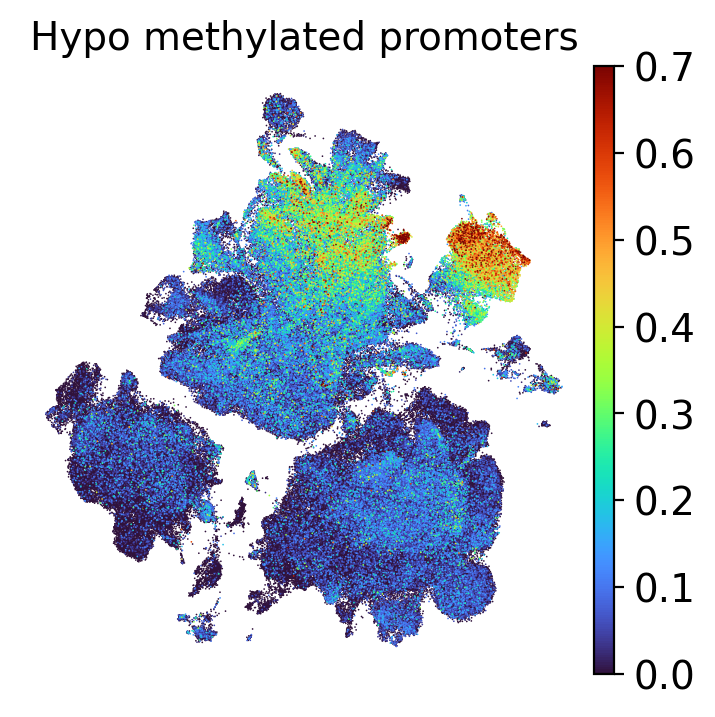

In [31]:
name = "low_promoters"
sc.pl.umap(adata, color=["{}_score".format(name)], 
            cmap=cmap, 
            ncols=1.5, 
            vmax=0.7,
            vmin=0,
            legend_fontsize=7, 
            legend_fontoutline=3, 
            s=1.5, 
            title=["Hypo methylated promoters"],
            save="_core_GBmap_titled_{}_turbo.pdf".format(name),
            frameon=False
              )

In [21]:
cmap = "Reds"

In [22]:
sub = adata.copy()

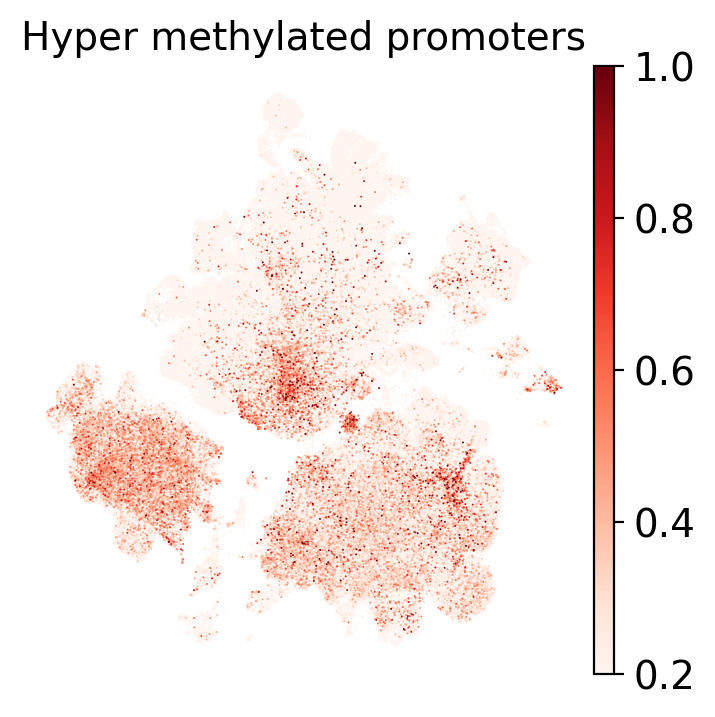

In [23]:
name = "high_promoters"
sub.obs.loc[sub.obs["{}_score".format(name)]<0.2, "{}_score".format(name)] = 0
sc.pl.umap(adata, color=["{}_score".format(name)], 
            cmap=cmap, 
            ncols=1.5, 
            vmax=1,
            vmin=0.2,
            legend_fontsize=7, 
            legend_fontoutline=3, 
            s=2, 
            title=["Hyper methylated promoters"],
            # save="_core_GBmap_titled_{}_turbo.pdf".format(name),
            frameon=False
              )

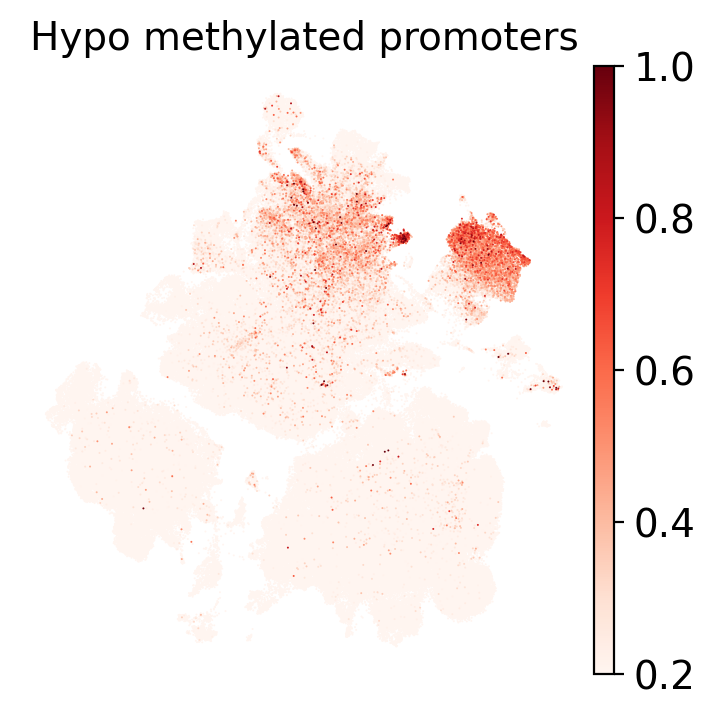

In [24]:
name = "low_promoters"
sub.obs.loc[sub.obs["{}_score".format(name)]<0.2, "{}_score".format(name)] = 0
sc.pl.umap(adata, color=["{}_score".format(name)], 
            cmap=cmap, 
            ncols=1.5, 
            vmax=1,
            vmin=0.2,
            legend_fontsize=7, 
            legend_fontoutline=3, 
            s=2, 
            title=["Hypo methylated promoters"],
            # save="_core_GBmap_titled_{}_turbo.pdf".format(name),
            frameon=False
              )

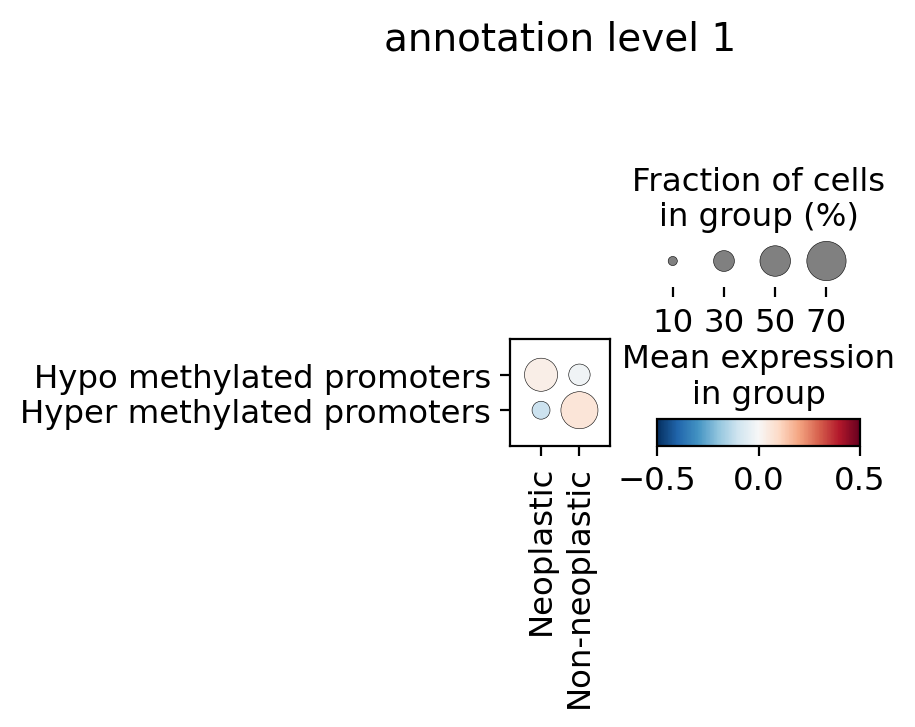

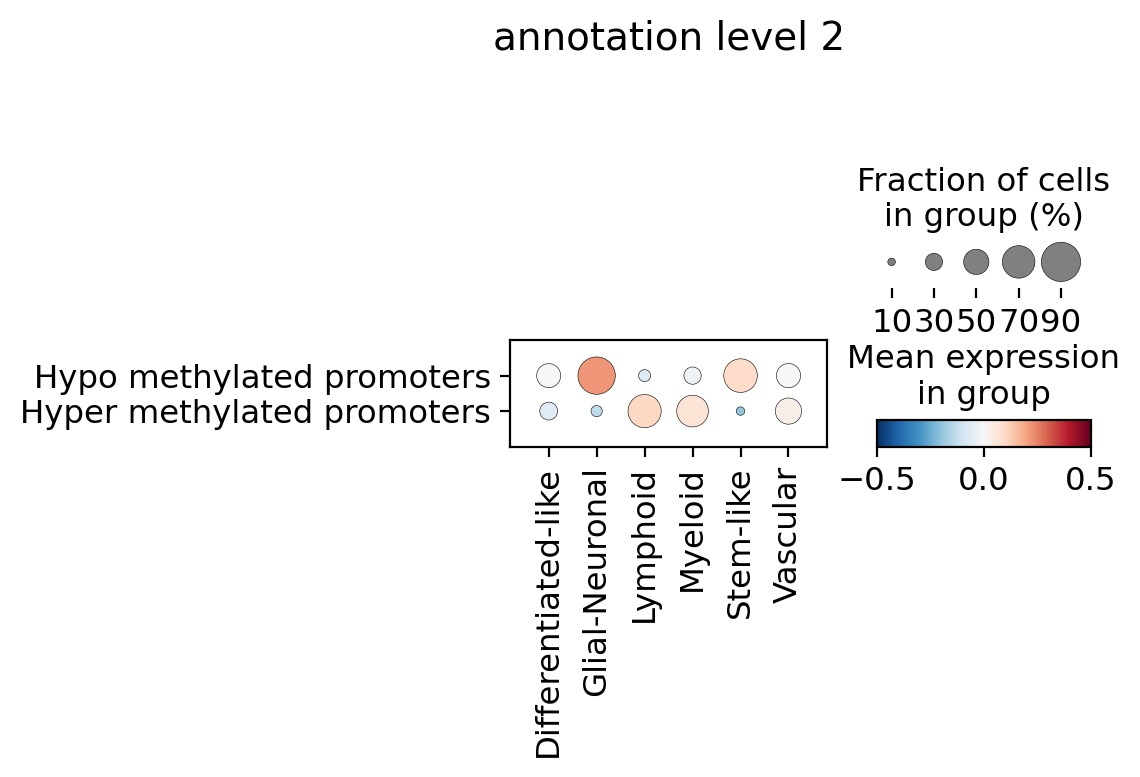

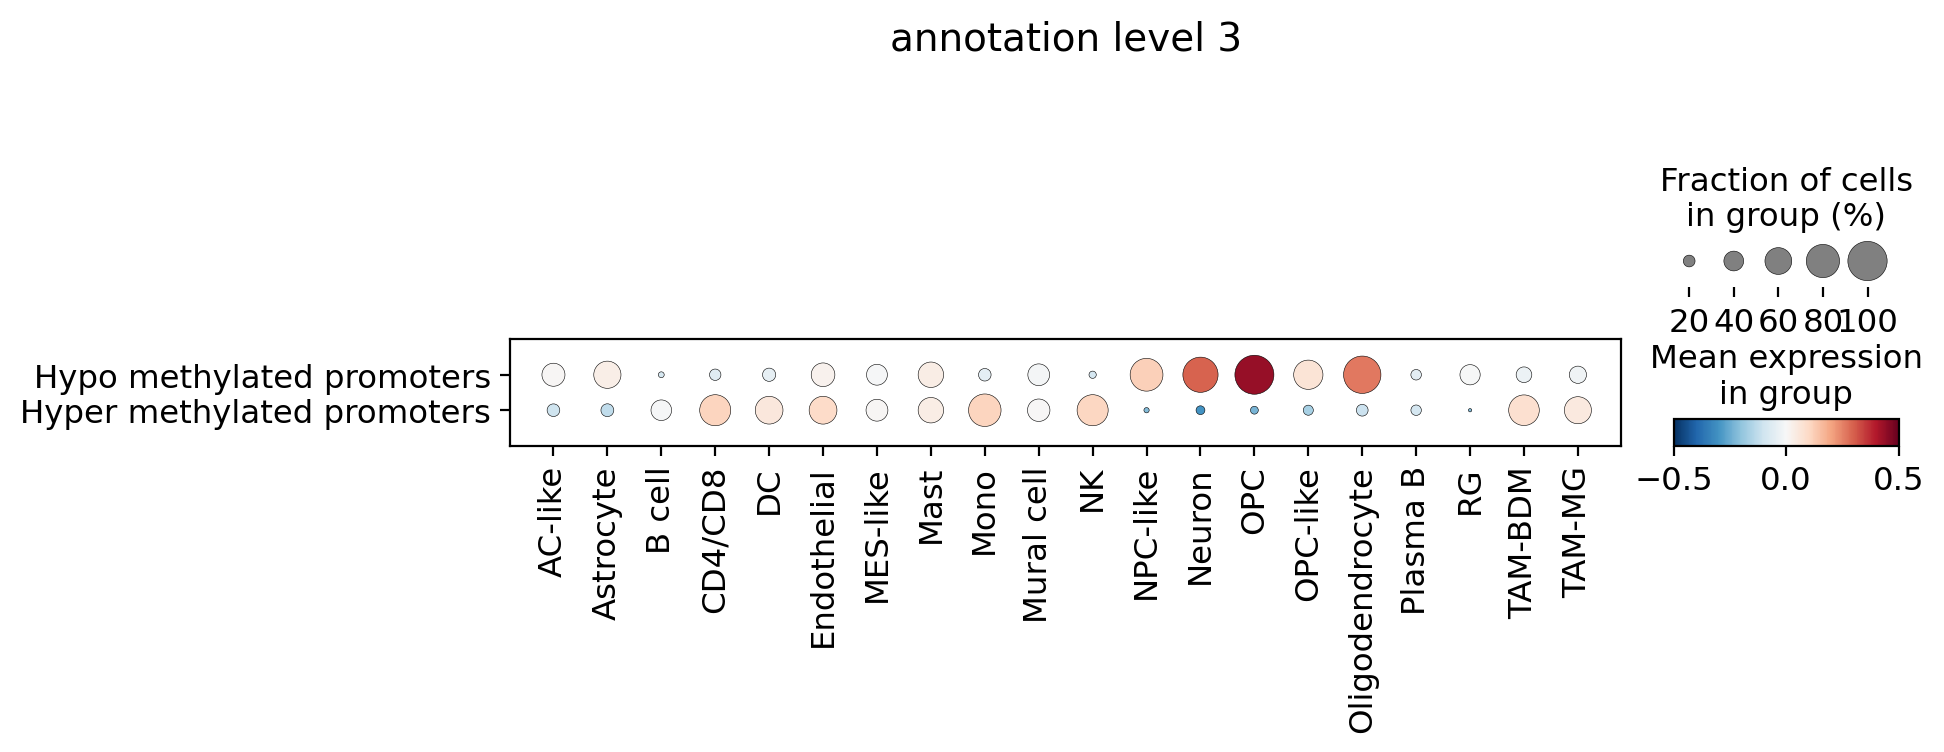

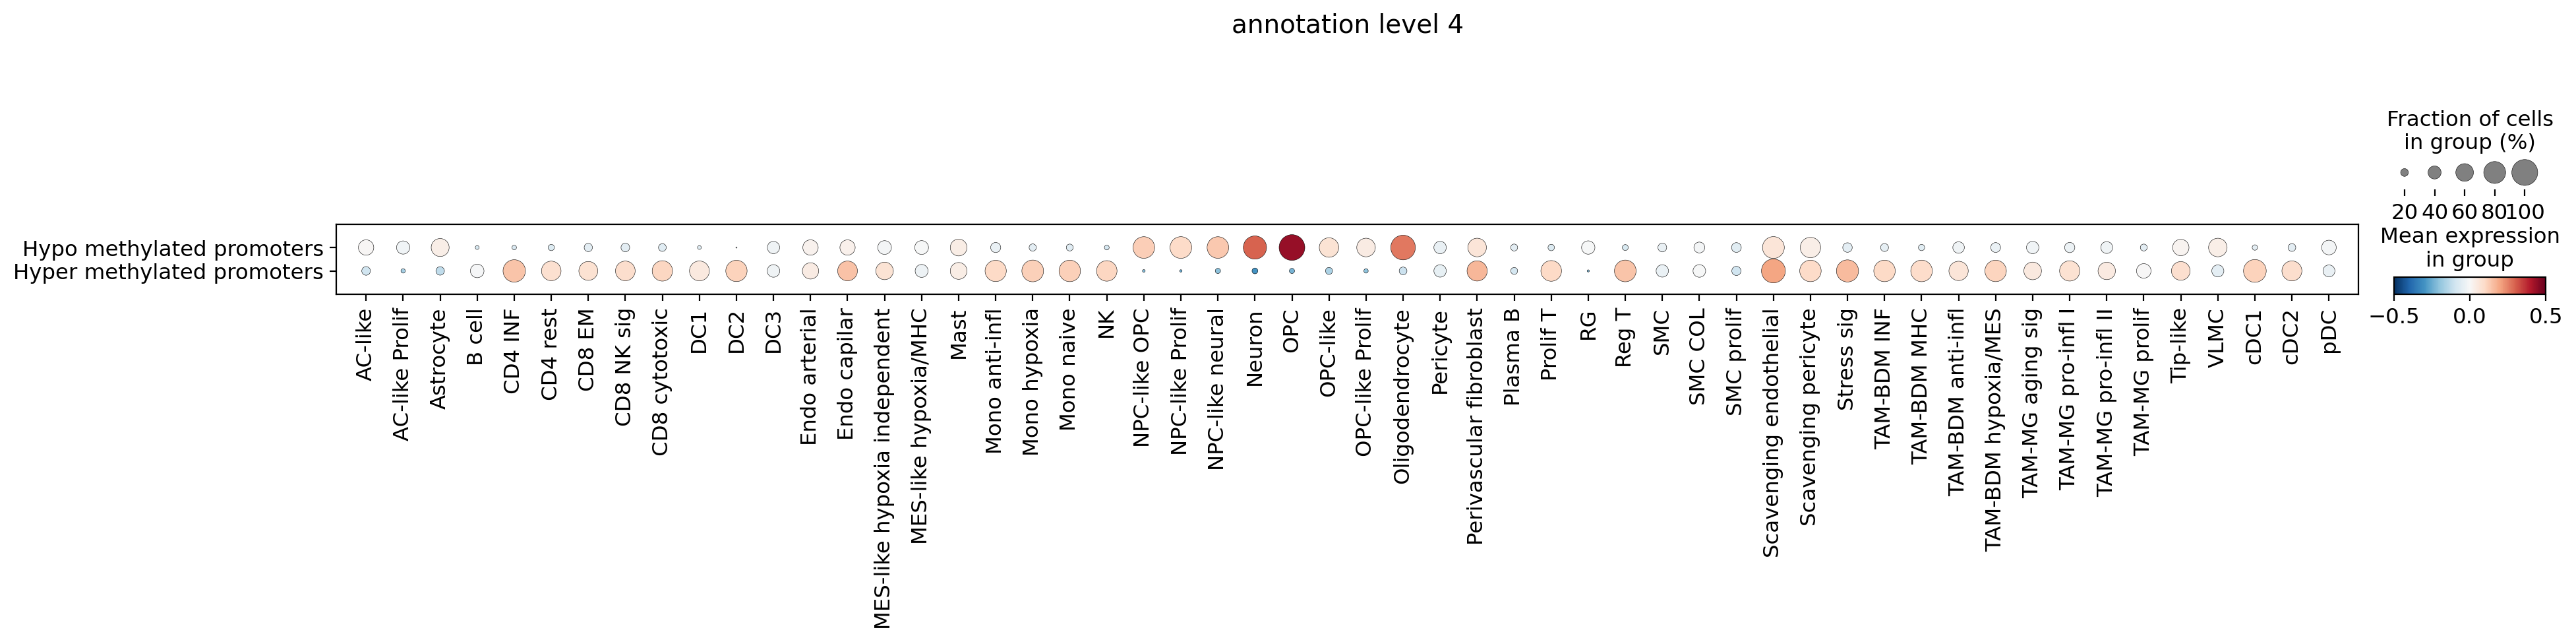

In [25]:
levels = sorted([col for col in adata.obs.columns if "annotation_level" in col])
for level in levels:
    ax = sc.pl.dotplot(adata, var_names=["low_promoters_score", "high_promoters_score"], groupby=level, use_raw=False, cmap="RdBu_r",
             vmin=-0.5, vmax=0.5, swap_axes=True, title=level.replace("_"," "), show=False, layer="scaled")
    ax['mainplot_ax'].set_yticklabels(["Hypo methylated promoters",
                                      "Hyper methylated promoters"])
    # plt.savefig(os.path.join("figures", "dotplot_core_GBmap_annotation_level_{}.pdf".format(level[-1])),
    #            bbox_inches="tight")